# LDA on simon's example

The LDA is a well-known probabilistic model to handle mixtures of topics in an unsupervised way.  It has been applied to a large number of problems (Blei, 2012).  The original paper has over 10000 citations (Blei, 2003).

   * My goal is to see if LDA methods have a place in phylogenetics
   * First let see if we can make it work on trees 


## Model formalism 

In statistical terms a generative model is a model for randomly generating observable data.  The model specifies a joint distribution over observed and latent variables.  The joint distribution for the LDA model can be shown as a graphical model.  There is also a generative story (see below) that can sometimes be more intuitive than the plate diagram.

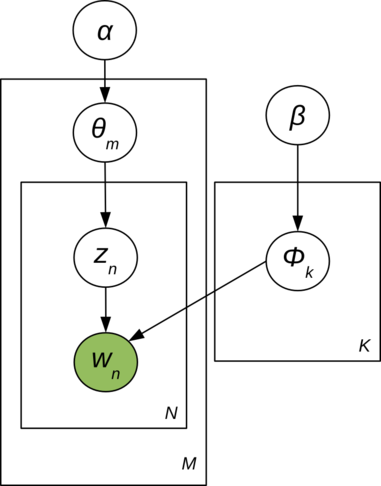

In [1]:
from IPython.display import Image

Image(filename='lda_plate.png')

Recall that the Dirichlet Process (DP) (Ferguson, 1973) is essentially a distribution over distributions, where each draw from a DP is itself a distribution and importantly for clustering applications it serves as a natural prior that lets the number of clusters grow as the data grows.  The DP has a base distribution parameter $\beta$ and a strength or concentration parameter $\alpha$.   

* $\alpha$ is a hyperprior for the DP over per-document topic distributions
* $\beta$ is the hyperprior for the DP over per-topic word distributions
* $\theta_{m}$ is the topic distribution for document $m$
* $\phi_{k}$ is the word distribution for topic $k$
* $z_{m,n}$ is the topic for the $n$th word in document $m$
* $w_{m,n}$ is the specific word 

## The generative story for phylogenetics

We are still modeling topics. However, **documents become sites** and **words become transitions**.  Transitions may defined in nucleotide, amino acid or codon space.

  * $\alpha$ is a hyperprior for the DP over per-site topic distributions
  * $\beta$ is the hyperprior for the DP over per-topic transition distributions
  * $\theta_{m}$ is the topic distribution for gene $m$
  * $\phi_{k}$ is the nucleotide transition distribution for topic $k$
  * $z_{m,n}$ is the topic for the $n$th nucleotide transition in gene $m$
  * $w_{m,n}$ is the specific transition

### The generative process
 
  1. Choose $\theta_{m} \sim \textrm{Dir}(\alpha)$, where $m \in \{1,...M\}$ and $\textrm{Dir}(\alpha)$ is the Dirichlet distribtion for $\alpha$
  2. Choose $\phi_{k} \sim \textrm{Dir}(\beta)$, where $k \in \{1,...K\}$
  3. For each of the transition positions ($m$,$n$), where $n \in \{1,...N\}$, and $m \in \{1,...M\}$  
  
     * Choose a topic $z_{m,n} \sim \textrm{Multinomial}(\theta_{m})$
     * Choose a transition $w_{m,n} \sim \textrm{Multinomial}(\phi_{m,n})$
     
$\phi$ is a $K*V$ Markov matrix each row of which denotes the transition distribution of a topic.

### Vocabulary and smoothing 

The vocabulary size ($V$) is the set of all types possible transitions that we want to consider.  Each codon transition can be represented as codon1-codon2-feature.  For example, CAC-CAT-CpG=True would represent a synonymous mutation for histidine in the vicinity of a CpG island.

The reason that $\beta$ is not connected directly to $w_{n}$ is that word in documents tend to be sparse and this formulation is a **smoothed** version of LDA and it tends to help with deal with the large number of zero probabilities.

## Generate some data for an example

First we specify the distributions that the sequences come from.

Then we generate sequences -- we assume that each codon is governed by a specific class and we are assuming only one mutations away from root sequence

Transform our sequences into codon transitions (i.e. words) ((61x61) - 61) if we ignore non-transitions

In [13]:
vocabulary = []
for cdn1 in sim.codons:
    for cdn2 in sim.codons:
        if cdn1 == cdn2:
            continue
        vocabulary.append(cdn1+"-"+cdn2)
print 'vocabulary: ', len(vocabulary)

transitions = np.zeros((N,M-1),).astype(str)

# transition relative to root
for i in range(sequences.shape[0]):
    for j in range(sequences.shape[1]):
        if j == sequences.shape[1] - 1:
            continue
        if sequences[i,0] == sequences[i,j+1]:
            transitions[i,j] = '-'
        else:
            transitions[i,j] = sequences[i,0]+"-"+sequences[i,j+1]
      
print transitions

vocabulary:  3660
[['-' '-' 'AGG-AAA' '-' 'AGG-CAT' 'AGG-CGT' 'AGG-CGA' 'AGG-CGG' '-']
 ['GTG-TTG' 'GTG-CTG' '-' 'GTG-GCG' 'GTG-CCC' '-' '-' '-' 'GTG-GCT']
 ['GCA-GTG' 'GCA-TTA' 'GCA-CTT' 'GCA-CCT' 'GCA-GTC' 'GCA-TTA' 'GCA-GTT'
  'GCA-GGG' 'GCA-GTC']
 ['-' 'ATT-ATC' 'ATT-GGA' '-' '-' 'ATT-GGA' 'ATT-GGA' 'ATT-GGT' 'ATT-TTG']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-']]


In [14]:
# convert words into vector

vocab = set([])
for w in range(transitions.shape[0]):
    posTransitions = transitions[w,:]
    for t in posTransitions:
        if t != '-':
            vocab.update([t])

vocab = list(vocab)
print vocab
## documents are positions in alignment
data = []
for w in range(transitions.shape[0]):
    posTransitions = transitions[w,:]
    document = []
    for v in vocab:
        document.append(len(np.where(posTransitions == v)[0]))
    data.append(document)
    print document
data = np.array(data)

['GCA-GTC', 'GCA-GGG', 'AGG-CGT', 'GCA-GTT', 'ATT-ATC', 'AGG-AAA', 'GTG-GCG', 'AGG-CAT', 'AGG-CGA', 'ATT-GGA', 'GCA-TTA', 'GTG-TTG', 'AGG-CGG', 'GCA-CTT', 'GCA-CCT', 'ATT-TTG', 'GTG-CCC', 'GTG-CTG', 'ATT-GGT', 'GTG-GCT', 'GCA-GTG']
[0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
[2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[****************100%******************]  5000 of 5000 completePlotting ptheta_0_0
Plotting ptheta_0_1
Plotting theta_4_0_0
Plotting theta_4_0_1
Plotting theta_4_0_2
Plotting ptheta_3_0
Plotting ptheta_3_1
Plotting ptheta_4_0
Plotting ptheta_4_1
Plotting theta_2_0_0
Plotting theta_2_0_1
Plotting theta_2_0_2
Plotting theta_0_0_0
Plotting theta_0_0_1
Plotting theta_0_0_2
Plotting theta_3_0_0
Plotting theta_3_0_1
Plotting theta_3_0_2
Plotting theta_1_0_0
Plotting theta_1_0_1
Plotting theta_1_0_2
Plotting ptheta_1_0
Plotting ptheta_1_1
Plotting ptheta_2_0
Plotting ptheta_2_1



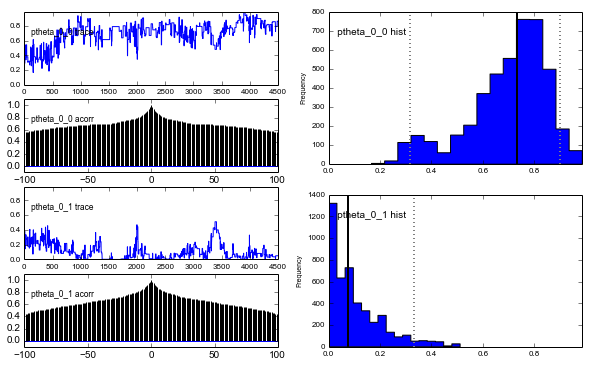

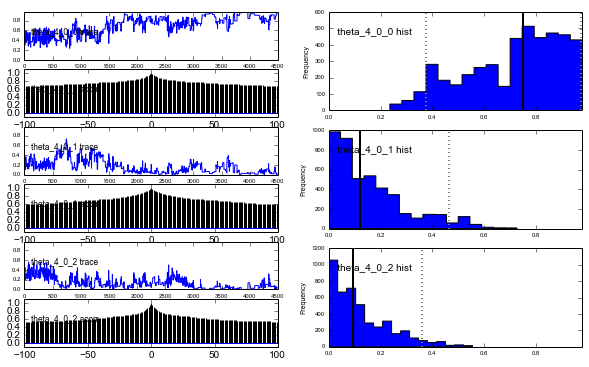

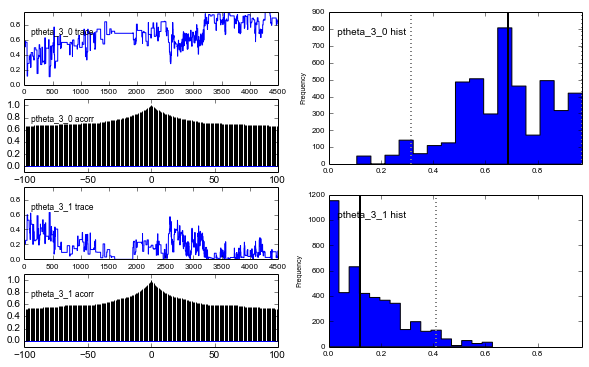

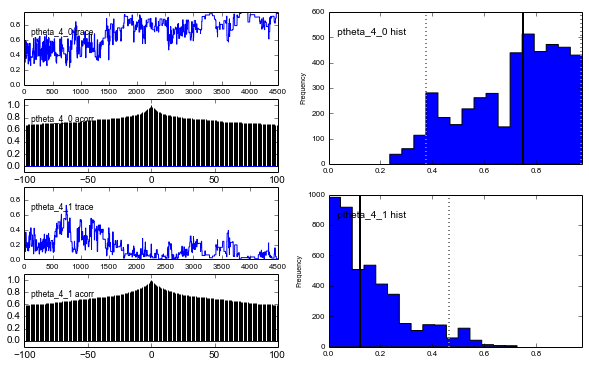

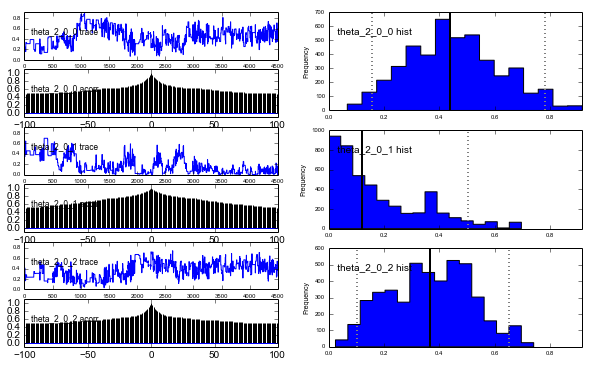

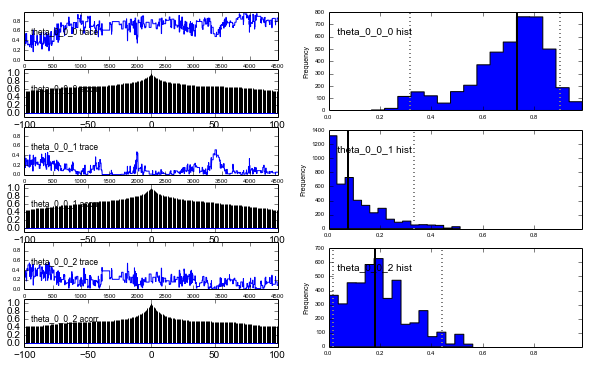

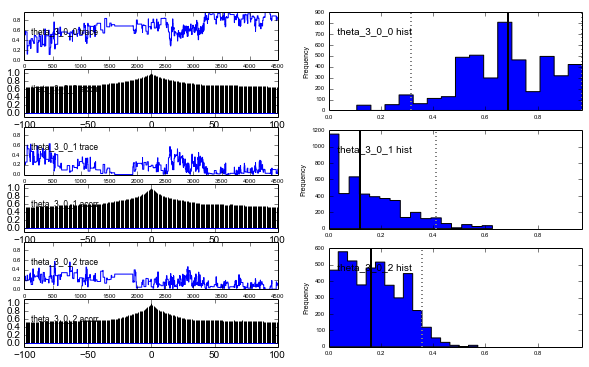

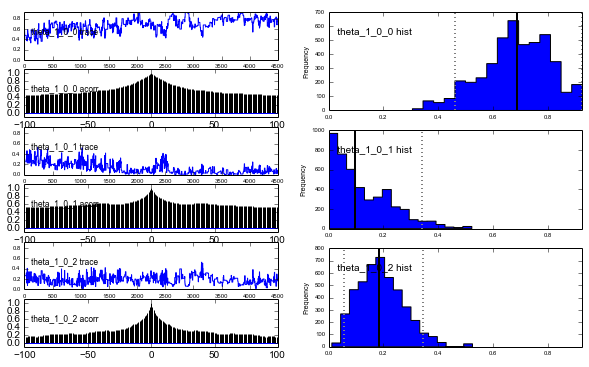

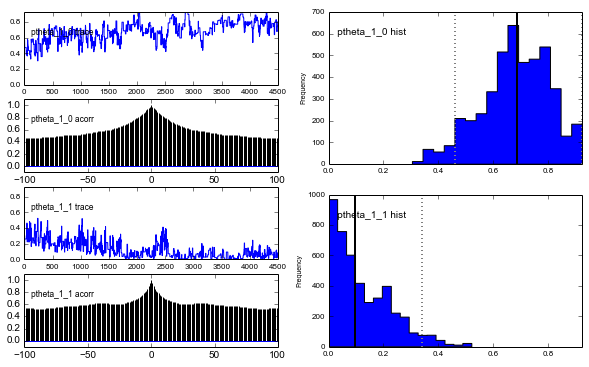

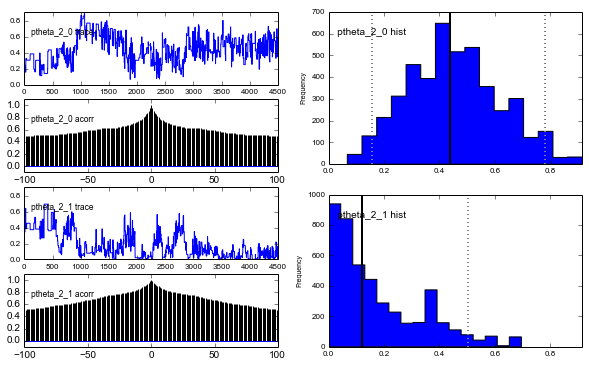

In [15]:
import numpy as np
import pymc as pm


K = 3 # number of topics                                                                                                                                       
V = len(vocab) # number of words                                                                                                                                        
D = 5 # number of documents                                                                                                                                    

#data = np.array([[1, 1, 1, 1], [1, 1, 1, 1], [0, 0, 0, 0]])

alpha = np.ones(K)
beta = np.ones(V)

theta = pm.Container([pm.CompletedDirichlet("theta_%s" % i, pm.Dirichlet("ptheta_%s" % i, theta=alpha)) for i in range(D)])
phi = pm.Container([pm.CompletedDirichlet("phi_%s" % k, pm.Dirichlet("pphi_%s" % k, theta=beta)) for k in range(K)])
Wd = [len(doc) for doc in data]

z = pm.Container([pm.Categorical('z_%i' % d,
                     p = theta[d],
                     size=Wd[d],
                     value=np.random.randint(K, size=Wd[d]))
                  for d in range(D)])

# cannot use p=phi[z[d][i]] here since phi is an ordinary list while z[d][i] is stochastic                                                                     
w = pm.Container([pm.Categorical("w_%i_%i" % (d,i),
                    p = pm.Lambda('phi_z_%i_%i' % (d,i),
                              lambda z=z[d][i], phi=phi: phi[z]),
                    value=data[d][i],
                    observed=True)
                  for d in range(D) for i in range(Wd[d])])

model = pm.Model([theta, phi, z, w])
#mcmc = pm.MCMC(model)                                                                                                                                         
#mcmc.sample(100)                                                                                                                                              

M = pm.MCMC(model)
M.sample(5000,burn=500)
pm.Matplot.plot(M)


## References

  * Blei, D. Probabilistic topic models Communications of the ACM, 2012, 55, 77-84
  * Blei, D. M.; Ng, A. Y. & Jordan, M. I. Latent Dirichlet Allocation Journal of Machine Learning Research, 2003, 3, 993-1022
  * Ferguson, T. S. A Bayesian Analysis of Some Nonparametric Problems The Annals of Statistics, 1973, 1, 209-230 
  * Huelsenbeck, J. P.; Jain, S.; Frost, S. W. D. & Pond, S. L. K. A Dirichlet process model for detecting positive selection in protein-coding DNA sequences PNAS, 2006, 103, 6263-8
  * Robinson, D. M.; Jones, D. T.; Kishino, H.; Goldman, N. & Thorne, J. L. Protein evolution with dependence among codons due to tertiary structure Mol. Biol. Evol., 2003, 20, 1692-1704
  * Rodrigue, N.; Kleinman, C. L.; Philippe, H. & Lartillot, N. Computational methods for evaluating phylogenetic models of coding sequence evolution with dependence between codons. Molecular biology and evolution, 2009, 26, 1663-76

  * simulation as a tree
  * distances using mutual information
  * can I reconstruct a similar tree
  * hemoglobin data (N. Rodrigue)
  * select a few applications of lda in biology for a better intro
  * data augmentation in simulation example to infer tree
  * cluster based on genewise topics (across columns)
  * quadruplit nature of sequences used to infer phylogenetic trees
  